In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
from pycaret.clustering import ClusteringExperiment

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import Image, display, Markdown
from IPython.core.display import HTML
import warnings

warnings.filterwarnings("ignore")

display(HTML("<style = font-size>pre {white-space: pre !important;}</style>"))

In [2]:
def KMeans_cluster(data, k):
    # 2. initialize the model
    my_kmeans = KMeans(n_clusters= k)

    # 3. fit the model to the data
    my_kmeans.fit(data) # pass your scaled data here
 
    # 4. obtain the cluster output
    clusters = my_kmeans.predict(data) # pass your scaled data here
    centroids = my_kmeans.cluster_centers_
    
    return clusters,  pd.DataFrame(centroids)
    # 5. attach the cluster output to our original DataFrame
#your_original_dataframe["cluster"] = clusters 

In [3]:
def clusters_num(data):
    inertia_list = []
    k = []
    sil_score = []
    for i in range(2,30):
        k.append(i)
        myKMeans = KMeans(n_clusters=i)
        myKMeans.fit(data)
        inertia_list.append(round(myKMeans.inertia_, 2))
        sil_score.append(round( silhouette_score(data, myKMeans.labels_), 2)) 
    return inertia_list ,  sil_score, k

In [4]:
data_dir = "./data/"

In [5]:
df_insurance = pd.read_csv(f"{data_dir}insurance.csv")
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Data Cleaning
df_insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# Feature Engeneering
df_insurance["born_year"] = (
    pd.Timestamp.now() - (df_insurance["age"] * np.timedelta64(365, "D"))
).dt.year
df_insurance["has_children"] = df_insurance["children"] > 0
df_insurance = pd.get_dummies(df_insurance, drop_first=True)

df_insurance

,age,bmi,children,charges,born_year,has_children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,2005,False,False,True,False,False,True
1,18,33.770,1,1725.55230,2006,True,True,False,False,True,False
2,28,33.000,3,4449.46200,1996,True,True,False,False,True,False
3,33,22.705,0,21984.47061,1991,False,True,False,True,False,False
4,32,28.880,0,3866.85520,1992,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1974,True,True,False,True,False,False
1334,18,31.920,0,2205.98080,2006,False,False,False,False,False,False
1335,18,36.850,0,1629.83350,2006,False,False,False,False,True,False
1336,21,25.800,0,2007.94500,2003,False,False,False,False,False,True


In [8]:
# Data Analysis
df_insurance.describe()

,age,bmi,children,charges,born_year
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,1984.792975
std,14.049960,6.098187,1.205493,12110.011237,14.049960
min,18.000000,15.960000,0.000000,1121.873900,1960.000000
25%,27.000000,26.296250,0.000000,4740.287150,1973.000000
50%,39.000000,30.400000,1.000000,9382.033000,1985.000000
75%,51.000000,34.693750,2.000000,16639.912515,1997.000000
max,64.000000,53.130000,5.000000,63770.428010,2006.000000


In [9]:
# Data Transformation
scaler = StandardScaler()
df_insurance['age'] = pd.DataFrame(scaler.fit_transform(df_insurance[['age']]))
df_insurance['bmi'] = pd.DataFrame(scaler.fit_transform(df_insurance[['bmi']]))
df_insurance['children'] = pd.DataFrame(scaler.fit_transform(df_insurance[['children']]))
df_insurance['charges'] = pd.DataFrame(scaler.fit_transform(df_insurance[['charges']]))
df_insurance['born_year'] = pd.DataFrame(scaler.fit_transform(df_insurance[['born_year']]))

df_insurance

,age,bmi,children,charges,born_year,has_children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0.298584,1.438764,False,False,True,False,False,True
1,-1.509965,0.509621,-0.078767,-0.953689,1.509965,True,True,False,False,True,False
2,-0.797954,0.383307,1.580926,-0.728675,0.797954,True,True,False,False,True,False
3,-0.441948,-1.305531,-0.908614,0.719843,0.441948,False,True,False,True,False,False
4,-0.513149,-0.292556,-0.908614,-0.776802,0.513149,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1333,0.768473,0.050297,1.580926,-0.220551,-0.768473,True,True,False,True,False,False
1334,-1.509965,0.206139,-0.908614,-0.914002,1.509965,False,False,False,False,False,False
1335,-1.509965,1.014878,-0.908614,-0.961596,1.509965,False,False,False,False,True,False
1336,-1.296362,-0.797813,-0.908614,-0.930362,1.296362,False,False,False,False,False,True


In [10]:
inertia_list, sil_score ,k = clusters_num(df_insurance)
inertia_list, sil_score ,k

([6142.16,
  5320.89,
  4527.8,
  4175.92,
  3865.43,
  3657.1,
  3391.08,
  3317.97,
  3062.01,
  2936.18,
  2861.97,
  2778.09,
  2707.7,
  2668.86,
  2590.22,
  2573.23,
  2462.43,
  2465.24,
  2407.91,
  2351.5,
  2300.04,
  2265.47,
  2266.0,
  2221.28,
  2158.2,
  2126.44,
  2119.38,
  2055.41],
 [0.24,
  0.21,
  0.23,
  0.2,
  0.18,
  0.18,
  0.19,
  0.17,
  0.17,
  0.18,
  0.17,
  0.17,
  0.16,
  0.16,
  0.16,
  0.15,
  0.16,
  0.15,
  0.15,
  0.15,
  0.15,
  0.15,
  0.14,
  0.14,
  0.16,
  0.15,
  0.15,
  0.16],
 [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29])

In [11]:
inertia_list = []
sil_score = []

for i in range(10):
    a, b , k = clusters_num(df_insurance)
    inertia_list.append(a)
    sil_score.append(b)

In [12]:
inertia_list_mean = np.mean(inertia_list,0)
sil_score_mean = np.mean(sil_score,0)

Text(0.5, 0, 'k')

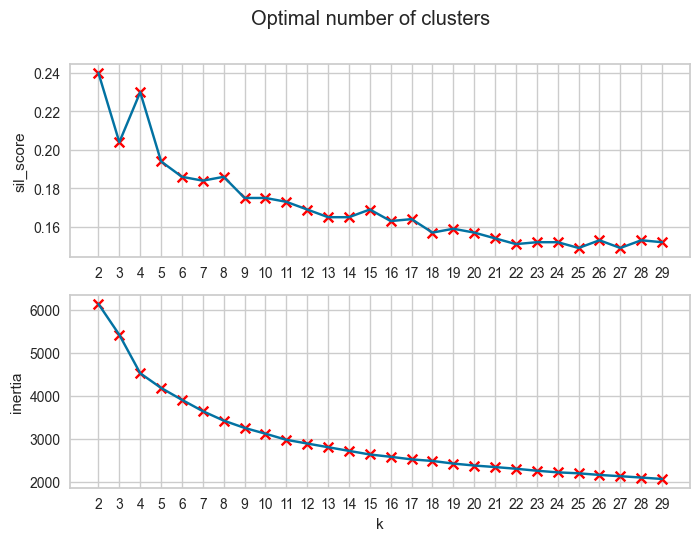

In [13]:
fig, axs = plt.subplots(2)
fig.suptitle('Optimal number of clusters')
axs[0].plot(k , sil_score_mean)
axs[0].scatter(k , sil_score_mean, marker='x', color = 'red')
axs[0].set_ylabel('sil_score')

axs[0].set_xticks(k)
axs[1].plot(k , inertia_list_mean)
axs[1].scatter(k , inertia_list_mean, marker='x', color = 'red')
axs[1].set_ylabel('inertia')
axs[1].set_xticks(k)
axs[1].set_xlabel('k')
#fig.savefig('Optimal number of clusters')

In [14]:
clusters, centroids = KMeans_cluster(df_insurance, 4)

In [15]:
df_insurance["cluster"] = clusters
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   float64
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   float64
 3   charges           1338 non-null   float64
 4   born_year         1338 non-null   float64
 5   has_children      1338 non-null   bool   
 6   sex_male          1338 non-null   bool   
 7   smoker_yes        1338 non-null   bool   
 8   region_northwest  1338 non-null   bool   
 9   region_southeast  1338 non-null   bool   
 10  region_southwest  1338 non-null   bool   
 11  cluster           1338 non-null   int32  
dtypes: bool(6), float64(5), int32(1)
memory usage: 65.5 KB


In [16]:
df_insurance

,age,bmi,children,charges,born_year,has_children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,cluster
0,-1.438764,-0.453320,-0.908614,0.298584,1.438764,False,False,True,False,False,True,1
1,-1.509965,0.509621,-0.078767,-0.953689,1.509965,True,True,False,False,True,False,1
2,-0.797954,0.383307,1.580926,-0.728675,0.797954,True,True,False,False,True,False,3
3,-0.441948,-1.305531,-0.908614,0.719843,0.441948,False,True,False,True,False,False,1
4,-0.513149,-0.292556,-0.908614,-0.776802,0.513149,False,True,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.768473,0.050297,1.580926,-0.220551,-0.768473,True,True,False,True,False,False,3
1334,-1.509965,0.206139,-0.908614,-0.914002,1.509965,False,False,False,False,False,False,1
1335,-1.509965,1.014878,-0.908614,-0.961596,1.509965,False,False,False,False,True,False,1
1336,-1.296362,-0.797813,-0.908614,-0.930362,1.296362,False,False,False,False,False,True,1


In [17]:
df_insurance['cluster'] = df_insurance['cluster'].astype('category')
df_insurance = pd.get_dummies(df_insurance, drop_first=True)
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   float64
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   float64
 3   charges           1338 non-null   float64
 4   born_year         1338 non-null   float64
 5   has_children      1338 non-null   bool   
 6   sex_male          1338 non-null   bool   
 7   smoker_yes        1338 non-null   bool   
 8   region_northwest  1338 non-null   bool   
 9   region_southeast  1338 non-null   bool   
 10  region_southwest  1338 non-null   bool   
 11  cluster_1         1338 non-null   bool   
 12  cluster_2         1338 non-null   bool   
 13  cluster_3         1338 non-null   bool   
dtypes: bool(9), float64(5)
memory usage: 64.2 KB


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>],
       [<Axes: title={'center': 'born_year'}>, <Axes: >]], dtype=object)

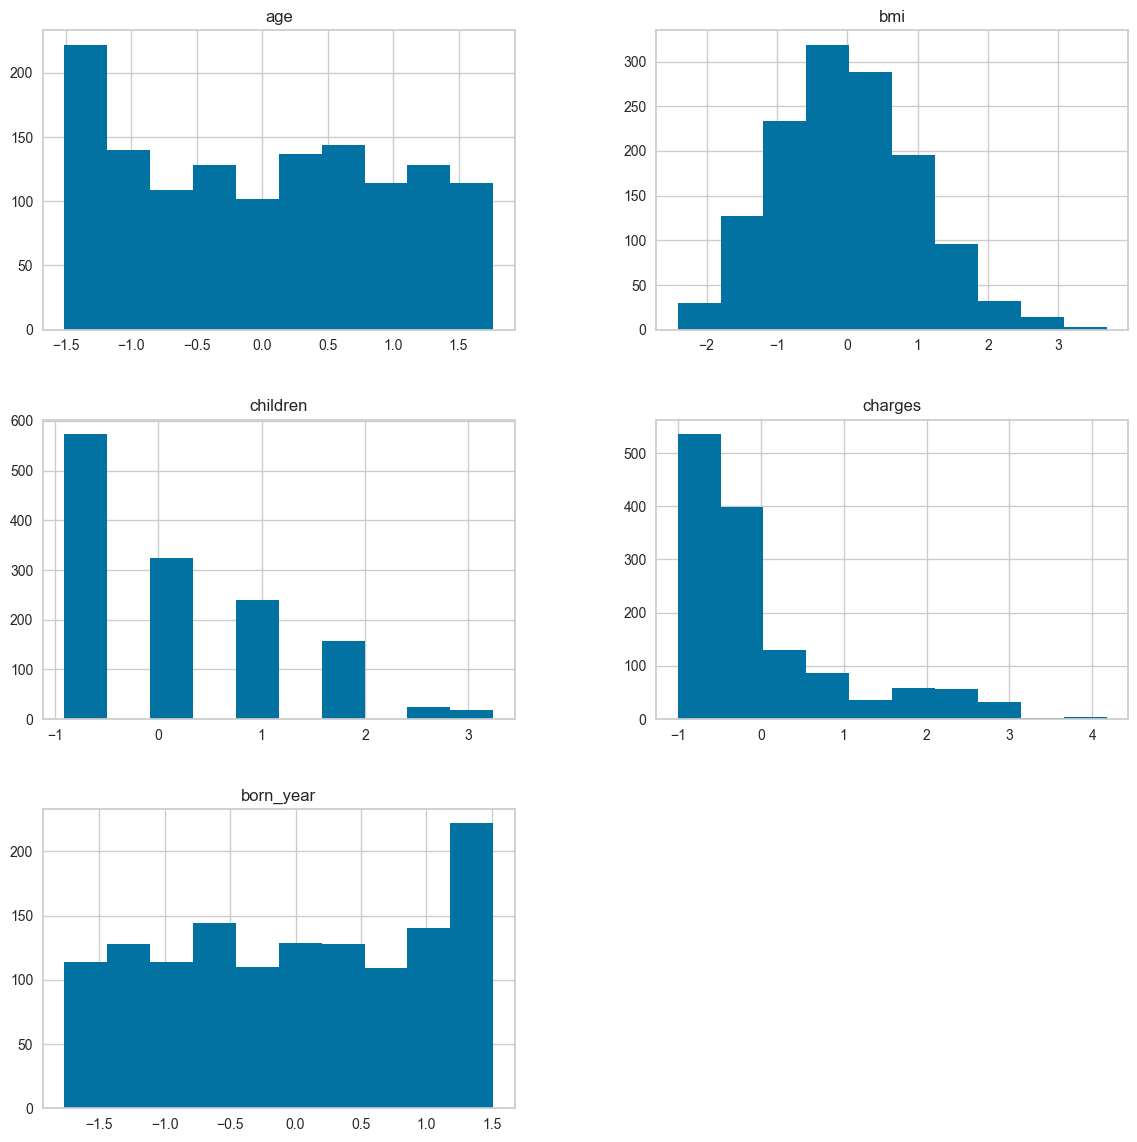

In [18]:
df_insurance.hist(figsize=(14, 14))

<Axes: >

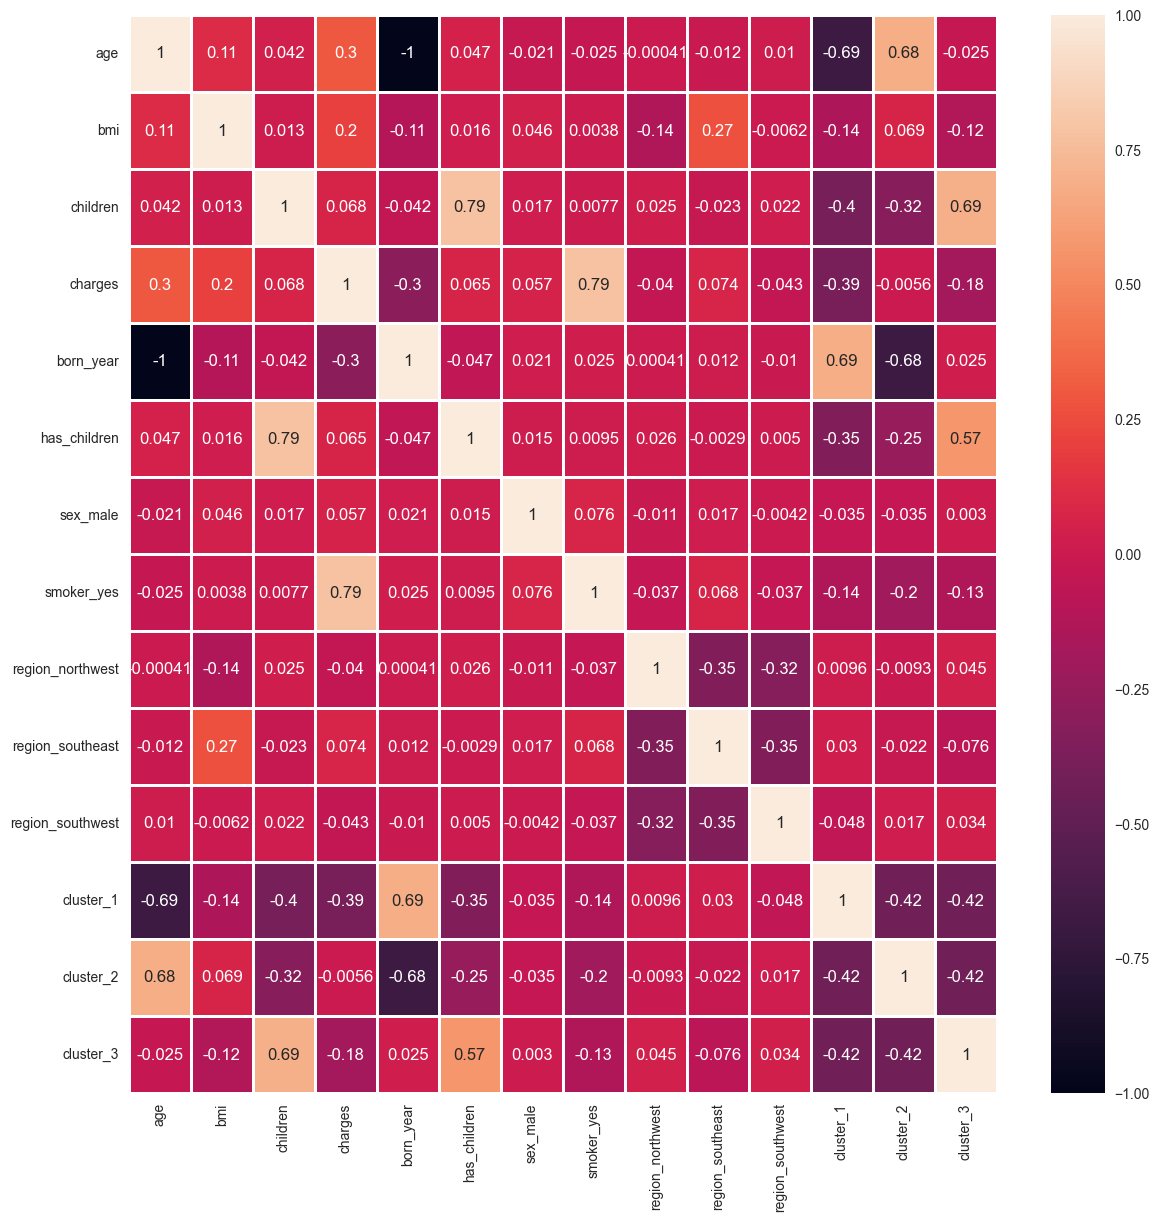

In [19]:
# Data Analysis
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_insurance.corr(), annot=True, linewidths=0.8)

In [20]:
train_data, test_data = train_test_split(df_insurance, train_size=0.8)

In [21]:
train_data.shape

(1070, 14)

In [22]:
test_data.shape

(268, 14)

In [ ]:
experiment = RegressionExperiment()
experiment.setup(data=train_data,
                 train_size=0.8,                 
                 target='charges',
                 session_id=123,
                 use_gpu=True)

In [24]:
best_model = experiment.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.1984,0.1293,0.3537,0.8574,0.1543,0.5953,0.0110
lr,Linear Regression,0.1984,0.1294,0.3538,0.8573,0.1540,0.5925,0.0090
ridge,Ridge Regression,0.2006,0.1298,0.3546,0.8569,0.1552,0.6151,0.0090
huber,Huber Regressor,0.1506,0.1357,0.3608,0.8501,0.1343,0.4712,0.0240
gbr,Gradient Boosting Regressor,0.2145,0.1453,0.3776,0.8410,0.1658,0.8678,0.0680
lightgbm,Light Gradient Boosting Machine,0.2423,0.1621,0.4003,0.8226,0.1785,1.0027,0.2610
rf,Random Forest Regressor,0.2282,0.1637,0.4019,0.8209,0.1767,0.8106,0.0780
et,Extra Trees Regressor,0.2186,0.1701,0.4101,0.8148,0.1796,0.8757,0.0560
ada,AdaBoost Regressor,0.3439,0.1817,0.4250,0.8015,0.2213,1.6947,0.0190
knn,K Neighbors Regressor,0.3008,0.2311,0.4780,0.7471,0.2121,1.0003,0.0220


In [25]:
experiment.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

In [26]:
predict_holdout = experiment.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.1707,0.1079,0.3285,0.9072,0.1303,0.6972


In [30]:
X_test = test_data.copy().drop('charges', axis=1)
predictions = experiment.predict_model(best_model, data=X_test)

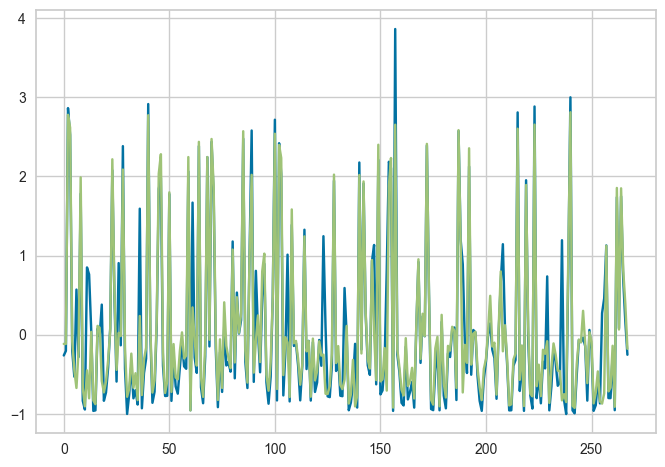

In [45]:
_test_data = test_data.sort_values(by='charges').reset_index(drop=True)
_predictions = predictions.sort_values(by='prediction_label').reset_index(drop=True)

plt.plot(_test_data.index, test_data['charges'].values)
plt.plot(_predictions.index, predictions['prediction_label'].values)
plt.show()